In [25]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

from crypr.models.train_model import TimeSeriesGenerator
from crypr.models.zoo import LSTM_triggerNG, LSTM_WSAEs, build_ae_lstm
import os, dotenv
project_path = os.path.dirname(dotenv.find_dotenv())

import pickle
import gc
p=print

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
"""
Import Data.
"""
SYM='BTC'
Ty=1
Tx=72
num_channels=1
wt_type='haar'
X_train=np.load('../data/processed/X_train_{}_{}_smooth_{}.npy'.format(SYM, wt_type, Tx))
X_test=np.load('../data/processed/X_test_{}_{}_smooth_{}.npy'.format(SYM, wt_type, Tx))
y_train=np.load('../data/processed/y_train_{}_{}_smooth_{}.npy'.format(SYM, wt_type, Tx))
y_test=np.load('../data/processed/y_test_{}_{}_smooth_{}.npy'.format(SYM, wt_type, Tx))

In [27]:
X_train.shape, X_test.shape, y_test.shape, y_train.shape

((15130, 72), (797, 72), (797, 1), (15130, 1))

In [40]:
if len(X_train.shape) < 3:
    model_X_train = np.swapaxes(np.expand_dims(X_train, axis=-1), axis1=-2, axis2=-1)
    model_X_test = np.swapaxes(np.expand_dims(X_test, axis=-1), axis1=-2, axis2=-1)
else:
    model_X_train = X_train
    model_X_test = X_test
model_X_train.shape

(15130, 1, 72)

In [29]:
"""
Evaluate Dummy Models.
"""

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

for strategy in ['mean', 'median', 'constant']:
    
    if strategy=='constant':
        dummy=DummyRegressor(strategy=strategy, constant=(0,))
    else:
        dummy=DummyRegressor(strategy=strategy)
        
    p('\nTraining dummy model on training data with strategy {} ...'.format(strategy))
    dummy.fit(X_train, y_train)
    
    p('\nPerformance on train data:')
    dummy_predict_train = dummy.predict(X_train)
    print('{} MAE: {}'.format(strategy, mean_absolute_error(y_true=y_train, y_pred=dummy_predict_train)))
    print('{} MSE: {}'.format(strategy, mean_squared_error(y_true=y_train, y_pred=dummy_predict_train)))
    
    p('\nPerformance on test data:')
    dummy_predict_test = dummy.predict(X_test)
    print('{} MAE: {}'.format(strategy, mean_absolute_error(y_true=y_test, y_pred=dummy_predict_test)))
    print('{} MSE: {}'.format(strategy, mean_squared_error(y_true=y_test, y_pred=dummy_predict_test)))


Training dummy model on training data with strategy mean ...

Performance on train data:
mean MAE: 0.6704191833149541
mean MSE: 1.1434823688554288

Performance on test data:
mean MAE: 0.27617677289849457
mean MSE: 0.2203102561304603

Training dummy model on training data with strategy median ...

Performance on train data:
median MAE: 0.6703710389694876
median MSE: 1.143547094825167

Performance on test data:
median MAE: 0.2768240780719447
median MSE: 0.22082193727421412

Training dummy model on training data with strategy constant ...

Performance on train data:
constant MAE: 0.6709792377853523
constant MSE: 1.143896644909049

Performance on test data:
constant MAE: 0.27555036295581686
constant MSE: 0.21959377436005295


In [30]:
from keras import Model
from keras.layers import Input, Dense, LSTM, BatchNormalization, Dropout, Reshape
from keras.regularizers import l2, l1

In [31]:
"""
Define model.
"""
model_type='ae_lstm'

if model_type=='ae_lstm':
    model=build_ae_lstm(num_inputs=model_X_train.shape[-1],num_channels=1,num_outputs=Ty)
else:
    model=None
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            (None, 1, 72)        0                                            
__________________________________________________________________________________________________
encoder (Dense)                 (None, 1, 36)        2628        input_0[0][0]                    
__________________________________________________________________________________________________
encoded (Dense)                 (None, 1, 18)        666         encoder[0][0]                    
__________________________________________________________________________________________________
rs_0 (Reshape)                  (None, 18, 1)        0           encoded[0][0]                    
__________________________________________________________________________________________________
lstm_0 (LS

In [32]:
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from time import time
"""
Set model training parameters.
"""
epochs = 10
batch_size = 32
learning_rate=.001
beta_1=0.9
beta_2=0.999
decay=0.01
# decay = learning_rate / epochs

"""
Compile and fit model.
"""
tensorboard = TensorBoard(log_dir='logs/{}'.format('ae_lstm_l1_10e-6'), 
                          histogram_freq=0, batch_size=batch_size, 
                         write_graph=True, write_grads=False, write_images=False)
opt = Adam(lr=learning_rate, beta_1=beta_1, beta_2=beta_2, decay=decay)
model.compile(loss='mae', optimizer=opt)

fit = model.fit(model_X_train, [model_X_train, y_train],
                shuffle=False,
                epochs=epochs, 
                batch_size=batch_size, 
                validation_data=(model_X_test, [model_X_test, y_test]),
                callbacks=[tensorboard]
               )

Train on 15130 samples, validate on 797 samples
Epoch 1/10
15130/15130 [==============================] - 24s 2ms/step - loss: 0.6921 - decoded_loss: 0.0169 - dense_0_loss: 0.6752 - val_loss: 0.3063 - val_decoded_loss: 0.0154 - val_dense_0_loss: 0.2909
Epoch 2/10
15130/15130 [==============================] - 21s 1ms/step - loss: 0.6874 - decoded_loss: 0.0155 - dense_0_loss: 0.6719 - val_loss: 0.2933 - val_decoded_loss: 0.0152 - val_dense_0_loss: 0.2781
Epoch 3/10
15130/15130 [==============================] - 23s 2ms/step - loss: 0.6865 - decoded_loss: 0.0153 - dense_0_loss: 0.6712 - val_loss: 0.2925 - val_decoded_loss: 0.0151 - val_dense_0_loss: 0.2773
Epoch 4/10
15130/15130 [==============================] - 24s 2ms/step - loss: 0.6855 - decoded_loss: 0.0152 - dense_0_loss: 0.6703 - val_loss: 0.2935 - val_decoded_loss: 0.0151 - val_dense_0_loss: 0.2784
Epoch 5/10
15130/15130 [==============================] - 25s 2ms/step - loss: 0.6854 - decoded_loss: 0.0152 - dense_0_loss: 0.6703 

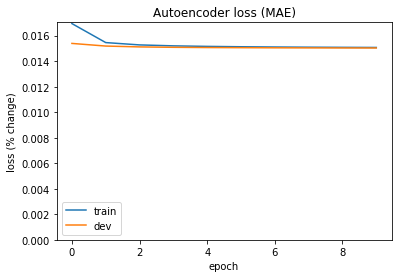

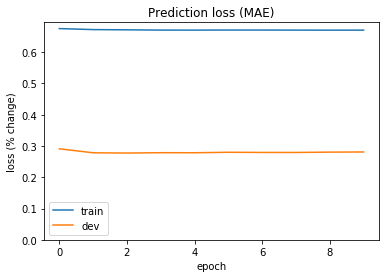

In [39]:
"""
Check out autoencoder loss from train and dev sets
"""
plt.plot(fit.history['decoded_loss'], label='train')
plt.plot(fit.history['val_decoded_loss'], label='dev')
plt.title('Autoencoder loss (MAE)')
plt.ylabel('loss (% change)')
plt.xlabel('epoch')
plt.ylim([0,None])
plt.legend()
plt.show()

"""
Check out prediction loss from train and dev sets
"""
plt.plot(fit.history['dense_0_loss'], label='train')
plt.plot(fit.history['val_dense_0_loss'], label='dev')
plt.title('Prediction loss (MAE)')
plt.ylabel('loss (% change)')
plt.xlabel('epoch')
plt.ylim([0,None])
plt.legend()
plt.show()

In [34]:
backtest=model.predict(model_X_train)[1]
prediction = model.predict(model_X_test)[1]

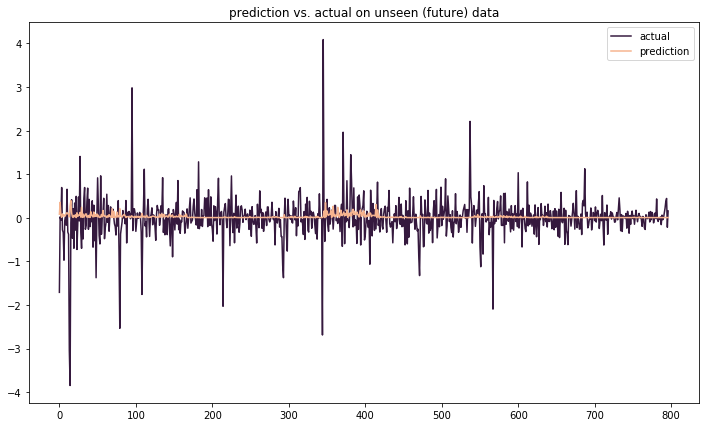

In [35]:
fig,ax=plt.subplots(figsize=(12,7))
plt.plot(y_test, c=sns.color_palette('rocket')[0], label='actual')
plt.plot(prediction, c=sns.color_palette('rocket')[5], label='prediction')
plt.title('prediction vs. actual on unseen (future) data')
plt.legend()

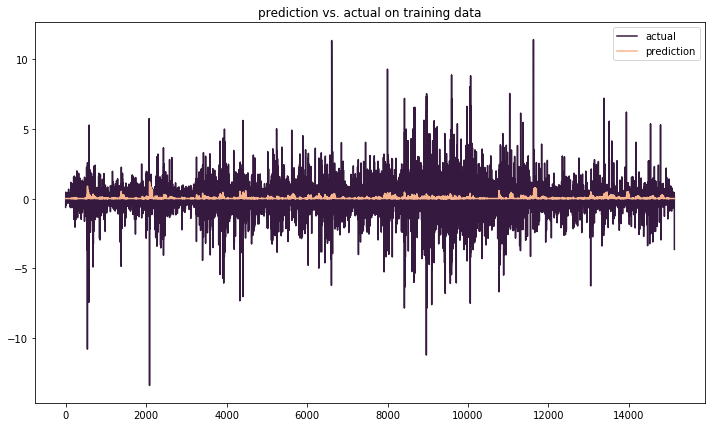

In [36]:
fig,ax=plt.subplots(figsize=(12,7))
plt.plot(y_train, c=sns.color_palette('rocket')[0], label='actual')
plt.plot(backtest, c=sns.color_palette('rocket')[5], label='prediction')
plt.title('prediction vs. actual on training data')
plt.legend()

In [141]:
"""
Save the model.
"""
model.save(filepath='../models/{}_smooth_{}x{}_{}_{}.h5'.format(model_type, num_channels, Tx, wavelet, SYM))